In [1]:
import pandas as pd
import numpy as np

import datetime

from itertools import product
import copy
import json
import pickle
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [4]:
from src.data_transformer import DataTransformer

### Data

In [6]:
transactions = pd.read_csv('data/train_transaction.csv')

In [7]:
# user id

transactions['D1n'] = np.floor(transactions.TransactionDT / (24*60*60)) - transactions.D1
transactions['uid'] = transactions.card1.astype(str) + '_' + transactions.addr1.astype(str) + '_' + transactions.D1n.astype(str)
transactions.drop('D1n', axis=1, inplace=True)

In [8]:
# train / val split per uid  (for VAE / for classifiaftion)
# train / val for classifiaftion

uid = transactions['uid'].unique()
uid_fraud = transactions.groupby('uid').isFraud.max()

uid_not_fraud = uid_fraud[uid_fraud==0].index.values
uid_fraud = uid_fraud[uid_fraud==1].index.values

np.random.shuffle(uid_not_fraud)
np.random.shuffle(uid_fraud)

val_rate = 0.15

n_train_not_fraud = int(uid_not_fraud.shape[0]*(1 - val_rate))
n_train_fraud = int(uid_fraud.shape[0]*(1 - val_rate))

# for VAE
uid_vae_train = uid_not_fraud[-n_train_not_fraud:]
uid_vae_val = uid_not_fraud[:-n_train_not_fraud]

# for classifiaftion
uid_cb_train = np.hstack([uid_not_fraud[:n_train_fraud], uid_fraud[:n_train_fraud]])
uid_cb_val = np.hstack([uid_not_fraud[n_train_fraud:-n_train_not_fraud], uid_fraud[n_train_fraud:]])

assert set(uid_vae_train) & set(uid_vae_val) == set()
assert set(uid_cb_train) & set(uid_cb_val) == set()
assert set(uid) == set(uid_vae_train) | set(uid_cb_train) | set(uid_cb_val)

index_vae_train = transactions[transactions.uid.isin(uid_vae_train)].index.values
np.random.shuffle(index_vae_train)
index_vae_val = transactions[transactions.uid.isin(uid_vae_val)].index.values
np.random.shuffle(index_vae_val)

index_cb_train = transactions[transactions.uid.isin(uid_cb_train)].index.values
np.random.shuffle(index_cb_train)
index_cb_val = transactions[transactions.uid.isin(uid_cb_val)].index.values
np.random.shuffle(index_cb_val)

assert set(transactions.index.values) == set(index_vae_train) | set(index_cb_train) | set(index_cb_val)

### Reconstruction quality: VAE

In [40]:
from sklearn.metrics import roc_auc_score

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme("paper")

from dgm.models import ad_Model, VAE
from dgm.utils import train_model, eval_model, plot_training_curves

In [170]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def uid_qintiles(df, model=model, data_transformer=data_transformer, m_in=1):
    # takes the m_in moost anomal transactions from all each uid's transactions
    df = df.reset_index(drop=True)
    _, errors = eval_model(model, 
           df,
           data_transformer,
           df.shape[0],
           verbose=False)
    indices = []
    errors = errors[0].sum(axis=1)
    for uid in df.uid.unique():
        mask = df.uid.values == uid
        error = errors[mask]
        index = df.index[mask]
        indices.extend(index[np.argpartition(error, len(error) - 1)][-m_in:])
    return indices

In [123]:
data_transformer = DataTransformer(transactions)
data_transformer.fit(transactions)

transaction_train = transactions.loc[index_vae_train, :]
transaction_val = transactions.loc[index_vae_val, :]

transaction_train = data_transformer.transform_data(transaction_train)
transaction_val = data_transformer.transform_data(transaction_val)

assert transaction_train.shape[1] == transaction_val.shape[1]
print(f'input dim: {data_transformer.get_batch(transaction_train.iloc[:7, :])[0].shape[1]}')

input dim: 728


In [124]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = torch.device('mps')

n_latent = 200
beta = 1

batch_size = 256
epochs = 150
lr = 0.0001

inputs = data_transformer.get_batch(transaction_train.iloc[:7, :])
model = ad_Model(VAE, inputs, n_latent, beta, device).to(device)

print(f'#parameters: {count_parameters(model)}')

train_losses, test_losses = train_model(model, 
            transaction_train,
            transaction_val,
            data_transformer,
            batch_size,
            epochs,
            lr,
            device=device,
            use_tqdm=True,
            verbose=False,
            loss_key="elbo_loss")

#parameters: 2967144


100%|███████████████████████████████████████| 150/150 [2:11:24<00:00, 52.57s/it]


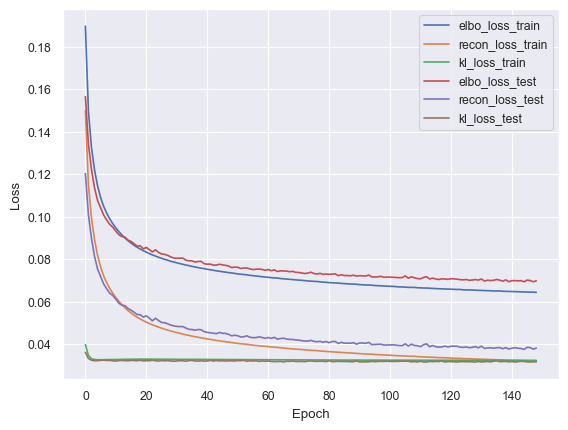

In [125]:
plot_training_curves(train_losses, test_losses)

In [126]:
tr_val = transactions.loc[index_cb_val, :]

tr_val = data_transformer.transform_data(tr_val)

one transaction:  gini: 0.3951, roc auc: 0.8157
all transactions: gini: 0.4964, roc auc: 0.7635


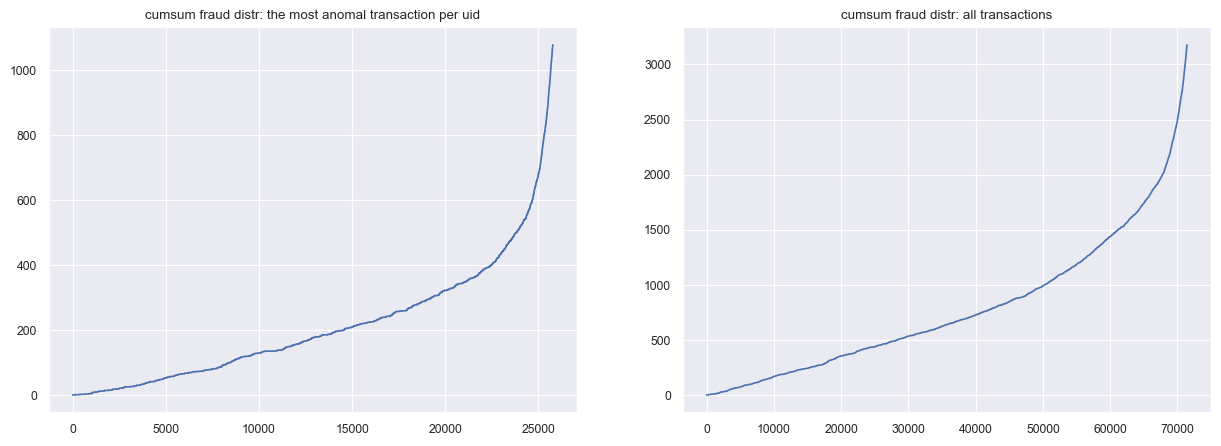

In [171]:
_, recon_quality = eval_model(model, 
           tr_val,
           data_transformer,
           tr_val.shape[0],
           verbose=False)

df = tr_val.loc[:, ['isFraud']]
df['recon_loss'] = np.hstack(recon_quality).sum(axis=1)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

index_one = uid_qintiles(tr_val, m_in=1)
x = recon_quality[0].sum(axis=1)[index_one]
y = tr_val.isFraud.values[index_one]
y_cumsum = np.cumsum(y[x.argsort()])
auc_one = roc_auc_score(y, x)
gini_1 = 2 * y_cumsum.sum() / len(x) / sum(y) 
ax[0].plot(range(len(x)), y_cumsum)
ax[0].set_title('cumsum fraud distr: the most anomal transaction per uid')

x = recon_quality[0].sum(axis=1)
y = tr_val.isFraud.values
y_cumsum = np.cumsum(y[x.argsort()])
auc_all = roc_auc_score(y, x)
gini_all = 2 * y_cumsum.sum() / len(x) / sum(y) 
ax[1].plot(range(len(x)), y_cumsum)
ax[1].set_title('cumsum fraud distr: all transactions')

print(f'one transaction:  gini: {gini_1:.4f}, roc auc: {auc_one:.4f}')
print(f'all transactions: gini: {gini_all:.4f}, roc auc: {auc_all:.4f}')

Text(0.5, 1.0, 'fraud / not fraud distr.: all transactions')

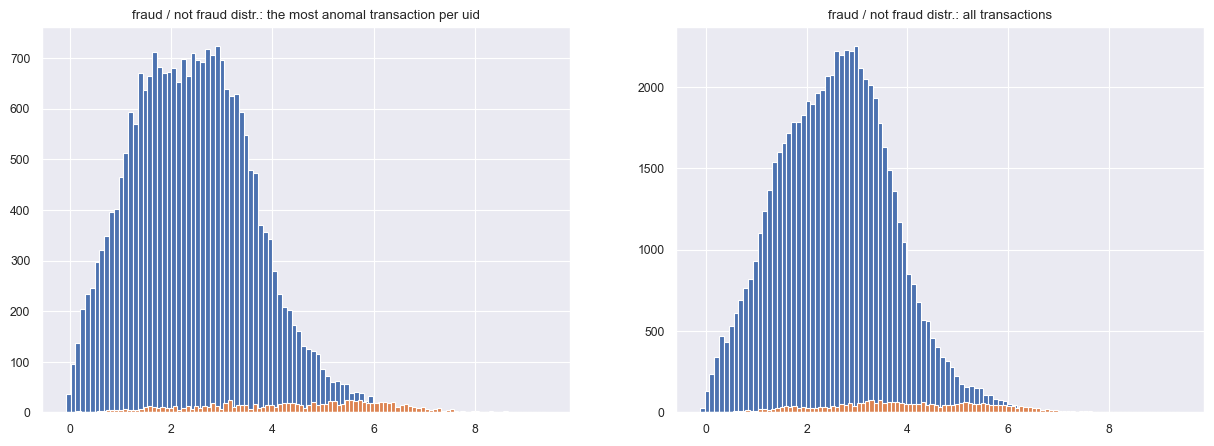

In [167]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

df['recon_loss_log'] = np.log(df['recon_loss'].values)

df[df.isFraud==0].recon_loss_log.hist(bins=100, ax=ax[1])
df[df.isFraud==1].recon_loss_log.hist(bins=100, ax=ax[1])

df = df.loc[df.index[index_one], :]
df[df.isFraud==0].recon_loss_log.hist(bins=100, ax=ax[0])
df[df.isFraud==1].recon_loss_log.hist(bins=100, ax=ax[0])

ax[0].set_title('fraud / not fraud distr.: the most anomal transaction per uid')
ax[1].set_title('fraud / not fraud distr.: all transactions')

### Classification

In [200]:
from catboost import CatBoostClassifier, Pool
import json

import json

def save_json(data, file_path):
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)

def load_json(file_path):
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data

In [226]:
transaction_train = transactions.loc[index_cb_train, :]
transaction_val = transactions.loc[index_cb_val, :]

transaction_train = data_transformer.transform_data(transaction_train)
transaction_val = data_transformer.transform_data(transaction_val)

to_drop = ['P_emaildomain', 'R_emaildomain']
emails = data_transformer.oh_text_encoder.transform(transaction_train).toarray()
emails = pd.DataFrame(emails, columns=['e' + str(i) for i in range(emails.shape[1])], index=transaction_train.index)
transaction_train = pd.concat([transaction_train.drop(to_drop, axis=1), emails], axis=1)

emails = data_transformer.oh_text_encoder.transform(transaction_val).toarray()
emails = pd.DataFrame(emails, columns=['e' + str(i) for i in range(emails.shape[1])], index=transaction_val.index)
transaction_val = pd.concat([transaction_val.drop(to_drop, axis=1), emails], axis=1)

m_in = 1
index = uid_qintiles(transaction_train, m_in=m_in)
transaction_train = transaction_train.reset_index(drop=True)
transaction_train = transaction_train.loc[index, :]

index = uid_qintiles(transaction_val, m_in=m_in)
transaction_val = transaction_val.reset_index(drop=True)
transaction_val = transaction_val.loc[index, :]

transaction_train.drop('uid', axis=1, inplace=True)
transaction_val.drop('uid', axis=1, inplace=True)


columns_to_drop = load_json('./artifacts/columns_to_drop.json')

transaction_train.drop(columns_to_drop, axis=1, inplace=True)
transaction_val.drop(columns_to_drop, axis=1, inplace=True)


In [133]:
cat_features = sl_data.cat_features
cat_features = list(set(transaction_train.columns.values) & set(cat_features))

for f in cat_features:
    if transaction_train[f].dtypes == 'float64':
        transaction_train[f] = transaction_train[f].astype(int)
        transaction_val[f] = transaction_val[f].astype(int)


train_data = Pool(
    transaction_train.iloc[:, 2:-1],
    transaction_train.iloc[:, 1],
    cat_features=cat_features
)

eval_data = Pool(
    transaction_val.iloc[:, 2:-1],
    transaction_val.iloc[:, 1],
    cat_features=cat_features
)

params = {"iterations": 2000,
          "learning_rate": 0.03,
          "depth": 7,
          "loss_function": "Logloss",
          "verbose": True,
          "eval_metric": "AUC"
         }

classifier = CatBoostClassifier(**params
                                )

classifier.fit(train_data,
               eval_set=eval_data,
               verbose=True,
               #plot=True
              )

0:	test: 0.8732247	best: 0.8732247 (0)	total: 56.4ms	remaining: 1m 52s
1:	test: 0.8811635	best: 0.8811635 (1)	total: 92.8ms	remaining: 1m 32s
2:	test: 0.8856422	best: 0.8856422 (2)	total: 132ms	remaining: 1m 27s
3:	test: 0.8866688	best: 0.8866688 (3)	total: 164ms	remaining: 1m 21s
4:	test: 0.8878812	best: 0.8878812 (4)	total: 196ms	remaining: 1m 18s
5:	test: 0.8897895	best: 0.8897895 (5)	total: 228ms	remaining: 1m 15s
6:	test: 0.8943885	best: 0.8943885 (6)	total: 264ms	remaining: 1m 15s
7:	test: 0.8955238	best: 0.8955238 (7)	total: 296ms	remaining: 1m 13s
8:	test: 0.8949169	best: 0.8955238 (7)	total: 330ms	remaining: 1m 13s
9:	test: 0.8950862	best: 0.8955238 (7)	total: 363ms	remaining: 1m 12s
10:	test: 0.8964136	best: 0.8964136 (10)	total: 393ms	remaining: 1m 11s
11:	test: 0.8967661	best: 0.8967661 (11)	total: 422ms	remaining: 1m 9s
12:	test: 0.8972335	best: 0.8972335 (12)	total: 456ms	remaining: 1m 9s
13:	test: 0.8967009	best: 0.8972335 (12)	total: 488ms	remaining: 1m 9s
14:	test: 0.8

117:	test: 0.9197674	best: 0.9197674 (117)	total: 3.75s	remaining: 59.8s
118:	test: 0.9198356	best: 0.9198356 (118)	total: 3.78s	remaining: 59.7s
119:	test: 0.9198483	best: 0.9198483 (119)	total: 3.81s	remaining: 59.7s
120:	test: 0.9199049	best: 0.9199049 (120)	total: 3.84s	remaining: 59.7s
121:	test: 0.9198858	best: 0.9199049 (120)	total: 3.88s	remaining: 59.7s
122:	test: 0.9199834	best: 0.9199834 (122)	total: 3.9s	remaining: 59.6s
123:	test: 0.9200598	best: 0.9200598 (123)	total: 3.94s	remaining: 59.6s
124:	test: 0.9201592	best: 0.9201592 (124)	total: 3.97s	remaining: 59.6s
125:	test: 0.9201945	best: 0.9201945 (125)	total: 4s	remaining: 59.6s
126:	test: 0.9202757	best: 0.9202757 (126)	total: 4.03s	remaining: 59.5s
127:	test: 0.9203234	best: 0.9203234 (127)	total: 4.07s	remaining: 59.5s
128:	test: 0.9203770	best: 0.9203770 (128)	total: 4.1s	remaining: 59.5s
129:	test: 0.9204125	best: 0.9204125 (129)	total: 4.13s	remaining: 59.4s
130:	test: 0.9204823	best: 0.9204823 (130)	total: 4.16s	

230:	test: 0.9249174	best: 0.9249174 (230)	total: 7.26s	remaining: 55.6s
231:	test: 0.9249629	best: 0.9249629 (231)	total: 7.29s	remaining: 55.5s
232:	test: 0.9249898	best: 0.9249898 (232)	total: 7.32s	remaining: 55.5s
233:	test: 0.9250316	best: 0.9250316 (233)	total: 7.35s	remaining: 55.5s
234:	test: 0.9250808	best: 0.9250808 (234)	total: 7.38s	remaining: 55.4s
235:	test: 0.9251550	best: 0.9251550 (235)	total: 7.41s	remaining: 55.4s
236:	test: 0.9251868	best: 0.9251868 (236)	total: 7.44s	remaining: 55.4s
237:	test: 0.9252292	best: 0.9252292 (237)	total: 7.47s	remaining: 55.3s
238:	test: 0.9252469	best: 0.9252469 (238)	total: 7.51s	remaining: 55.3s
239:	test: 0.9252370	best: 0.9252469 (238)	total: 7.54s	remaining: 55.3s
240:	test: 0.9252642	best: 0.9252642 (240)	total: 7.57s	remaining: 55.2s
241:	test: 0.9253047	best: 0.9253047 (241)	total: 7.6s	remaining: 55.2s
242:	test: 0.9254066	best: 0.9254066 (242)	total: 7.63s	remaining: 55.2s
243:	test: 0.9254165	best: 0.9254165 (243)	total: 7.

344:	test: 0.9283199	best: 0.9283199 (344)	total: 10.8s	remaining: 51.8s
345:	test: 0.9283486	best: 0.9283486 (345)	total: 10.8s	remaining: 51.8s
346:	test: 0.9283737	best: 0.9283737 (346)	total: 10.9s	remaining: 51.8s
347:	test: 0.9284002	best: 0.9284002 (347)	total: 10.9s	remaining: 51.8s
348:	test: 0.9284155	best: 0.9284155 (348)	total: 10.9s	remaining: 51.7s
349:	test: 0.9284667	best: 0.9284667 (349)	total: 11s	remaining: 51.7s
350:	test: 0.9284661	best: 0.9284667 (349)	total: 11s	remaining: 51.7s
351:	test: 0.9284441	best: 0.9284667 (349)	total: 11s	remaining: 51.6s
352:	test: 0.9285034	best: 0.9285034 (352)	total: 11.1s	remaining: 51.6s
353:	test: 0.9285083	best: 0.9285083 (353)	total: 11.1s	remaining: 51.6s
354:	test: 0.9285295	best: 0.9285295 (354)	total: 11.1s	remaining: 51.6s
355:	test: 0.9285376	best: 0.9285376 (355)	total: 11.2s	remaining: 51.5s
356:	test: 0.9285536	best: 0.9285536 (356)	total: 11.2s	remaining: 51.5s
357:	test: 0.9285276	best: 0.9285536 (356)	total: 11.2s	r

462:	test: 0.9300320	best: 0.9300320 (462)	total: 14.5s	remaining: 48.2s
463:	test: 0.9300359	best: 0.9300359 (463)	total: 14.6s	remaining: 48.2s
464:	test: 0.9300308	best: 0.9300359 (463)	total: 14.6s	remaining: 48.1s
465:	test: 0.9300595	best: 0.9300595 (465)	total: 14.6s	remaining: 48.1s
466:	test: 0.9300823	best: 0.9300823 (466)	total: 14.7s	remaining: 48.1s
467:	test: 0.9300971	best: 0.9300971 (467)	total: 14.7s	remaining: 48.1s
468:	test: 0.9300977	best: 0.9300977 (468)	total: 14.7s	remaining: 48.1s
469:	test: 0.9300995	best: 0.9300995 (469)	total: 14.8s	remaining: 48s
470:	test: 0.9300570	best: 0.9300995 (469)	total: 14.8s	remaining: 48s
471:	test: 0.9300564	best: 0.9300995 (469)	total: 14.8s	remaining: 48s
472:	test: 0.9300489	best: 0.9300995 (469)	total: 14.8s	remaining: 47.9s
473:	test: 0.9300508	best: 0.9300995 (469)	total: 14.9s	remaining: 47.9s
474:	test: 0.9300594	best: 0.9300995 (469)	total: 14.9s	remaining: 47.9s
475:	test: 0.9300695	best: 0.9300995 (469)	total: 14.9s	r

577:	test: 0.9313219	best: 0.9313264 (572)	total: 18.2s	remaining: 44.7s
578:	test: 0.9313015	best: 0.9313264 (572)	total: 18.2s	remaining: 44.6s
579:	test: 0.9313010	best: 0.9313264 (572)	total: 18.2s	remaining: 44.6s
580:	test: 0.9313583	best: 0.9313583 (580)	total: 18.2s	remaining: 44.6s
581:	test: 0.9314093	best: 0.9314093 (581)	total: 18.3s	remaining: 44.5s
582:	test: 0.9314143	best: 0.9314143 (582)	total: 18.3s	remaining: 44.5s
583:	test: 0.9314282	best: 0.9314282 (583)	total: 18.3s	remaining: 44.5s
584:	test: 0.9314405	best: 0.9314405 (584)	total: 18.4s	remaining: 44.4s
585:	test: 0.9314654	best: 0.9314654 (585)	total: 18.4s	remaining: 44.4s
586:	test: 0.9314479	best: 0.9314654 (585)	total: 18.4s	remaining: 44.4s
587:	test: 0.9314533	best: 0.9314654 (585)	total: 18.5s	remaining: 44.4s
588:	test: 0.9314739	best: 0.9314739 (588)	total: 18.5s	remaining: 44.3s
589:	test: 0.9315224	best: 0.9315224 (589)	total: 18.5s	remaining: 44.3s
590:	test: 0.9315383	best: 0.9315383 (590)	total: 1

695:	test: 0.9321844	best: 0.9321844 (695)	total: 21.9s	remaining: 40.9s
696:	test: 0.9321972	best: 0.9321972 (696)	total: 21.9s	remaining: 40.9s
697:	test: 0.9321959	best: 0.9321972 (696)	total: 21.9s	remaining: 40.9s
698:	test: 0.9321954	best: 0.9321972 (696)	total: 21.9s	remaining: 40.8s
699:	test: 0.9321939	best: 0.9321972 (696)	total: 22s	remaining: 40.8s
700:	test: 0.9321684	best: 0.9321972 (696)	total: 22s	remaining: 40.8s
701:	test: 0.9321702	best: 0.9321972 (696)	total: 22s	remaining: 40.7s
702:	test: 0.9321908	best: 0.9321972 (696)	total: 22.1s	remaining: 40.7s
703:	test: 0.9321924	best: 0.9321972 (696)	total: 22.1s	remaining: 40.7s
704:	test: 0.9321960	best: 0.9321972 (696)	total: 22.1s	remaining: 40.7s
705:	test: 0.9321885	best: 0.9321972 (696)	total: 22.2s	remaining: 40.6s
706:	test: 0.9322119	best: 0.9322119 (706)	total: 22.2s	remaining: 40.6s
707:	test: 0.9322127	best: 0.9322127 (707)	total: 22.2s	remaining: 40.6s
708:	test: 0.9322056	best: 0.9322127 (707)	total: 22.3s	r

813:	test: 0.9324714	best: 0.9324804 (807)	total: 25.6s	remaining: 37.3s
814:	test: 0.9324681	best: 0.9324804 (807)	total: 25.6s	remaining: 37.3s
815:	test: 0.9324931	best: 0.9324931 (815)	total: 25.7s	remaining: 37.2s
816:	test: 0.9325198	best: 0.9325198 (816)	total: 25.7s	remaining: 37.2s
817:	test: 0.9325196	best: 0.9325198 (816)	total: 25.7s	remaining: 37.2s
818:	test: 0.9324990	best: 0.9325198 (816)	total: 25.8s	remaining: 37.1s
819:	test: 0.9324936	best: 0.9325198 (816)	total: 25.8s	remaining: 37.1s
820:	test: 0.9325064	best: 0.9325198 (816)	total: 25.8s	remaining: 37.1s
821:	test: 0.9325058	best: 0.9325198 (816)	total: 25.9s	remaining: 37s
822:	test: 0.9325181	best: 0.9325198 (816)	total: 25.9s	remaining: 37s
823:	test: 0.9325239	best: 0.9325239 (823)	total: 25.9s	remaining: 37s
824:	test: 0.9325350	best: 0.9325350 (824)	total: 25.9s	remaining: 36.9s
825:	test: 0.9325456	best: 0.9325456 (825)	total: 26s	remaining: 36.9s
826:	test: 0.9325467	best: 0.9325467 (826)	total: 26s	remai

931:	test: 0.9328337	best: 0.9328920 (906)	total: 29.3s	remaining: 33.6s
932:	test: 0.9328468	best: 0.9328920 (906)	total: 29.4s	remaining: 33.6s
933:	test: 0.9328507	best: 0.9328920 (906)	total: 29.4s	remaining: 33.6s
934:	test: 0.9328582	best: 0.9328920 (906)	total: 29.4s	remaining: 33.5s
935:	test: 0.9328618	best: 0.9328920 (906)	total: 29.5s	remaining: 33.5s
936:	test: 0.9328663	best: 0.9328920 (906)	total: 29.5s	remaining: 33.5s
937:	test: 0.9328455	best: 0.9328920 (906)	total: 29.5s	remaining: 33.4s
938:	test: 0.9328208	best: 0.9328920 (906)	total: 29.6s	remaining: 33.4s
939:	test: 0.9328181	best: 0.9328920 (906)	total: 29.6s	remaining: 33.4s
940:	test: 0.9328003	best: 0.9328920 (906)	total: 29.6s	remaining: 33.3s
941:	test: 0.9328061	best: 0.9328920 (906)	total: 29.7s	remaining: 33.3s
942:	test: 0.9328113	best: 0.9328920 (906)	total: 29.7s	remaining: 33.3s
943:	test: 0.9328218	best: 0.9328920 (906)	total: 29.7s	remaining: 33.2s
944:	test: 0.9328330	best: 0.9328920 (906)	total: 2

1049:	test: 0.9328372	best: 0.9329597 (977)	total: 33.1s	remaining: 29.9s
1050:	test: 0.9328367	best: 0.9329597 (977)	total: 33.1s	remaining: 29.9s
1051:	test: 0.9328381	best: 0.9329597 (977)	total: 33.2s	remaining: 29.9s
1052:	test: 0.9328337	best: 0.9329597 (977)	total: 33.2s	remaining: 29.9s
1053:	test: 0.9328400	best: 0.9329597 (977)	total: 33.2s	remaining: 29.8s
1054:	test: 0.9328629	best: 0.9329597 (977)	total: 33.3s	remaining: 29.8s
1055:	test: 0.9328580	best: 0.9329597 (977)	total: 33.3s	remaining: 29.8s
1056:	test: 0.9328416	best: 0.9329597 (977)	total: 33.3s	remaining: 29.7s
1057:	test: 0.9328573	best: 0.9329597 (977)	total: 33.3s	remaining: 29.7s
1058:	test: 0.9328686	best: 0.9329597 (977)	total: 33.4s	remaining: 29.7s
1059:	test: 0.9328703	best: 0.9329597 (977)	total: 33.4s	remaining: 29.6s
1060:	test: 0.9328525	best: 0.9329597 (977)	total: 33.4s	remaining: 29.6s
1061:	test: 0.9328508	best: 0.9329597 (977)	total: 33.5s	remaining: 29.6s
1062:	test: 0.9328495	best: 0.9329597 

1161:	test: 0.9332336	best: 0.9332342 (1159)	total: 36.7s	remaining: 26.4s
1162:	test: 0.9332323	best: 0.9332342 (1159)	total: 36.7s	remaining: 26.4s
1163:	test: 0.9332307	best: 0.9332342 (1159)	total: 36.7s	remaining: 26.4s
1164:	test: 0.9332345	best: 0.9332345 (1164)	total: 36.8s	remaining: 26.4s
1165:	test: 0.9332562	best: 0.9332562 (1165)	total: 36.8s	remaining: 26.3s
1166:	test: 0.9332468	best: 0.9332562 (1165)	total: 36.8s	remaining: 26.3s
1167:	test: 0.9332701	best: 0.9332701 (1167)	total: 36.9s	remaining: 26.3s
1168:	test: 0.9332510	best: 0.9332701 (1167)	total: 36.9s	remaining: 26.2s
1169:	test: 0.9332137	best: 0.9332701 (1167)	total: 36.9s	remaining: 26.2s
1170:	test: 0.9332262	best: 0.9332701 (1167)	total: 37s	remaining: 26.2s
1171:	test: 0.9332253	best: 0.9332701 (1167)	total: 37s	remaining: 26.1s
1172:	test: 0.9332489	best: 0.9332701 (1167)	total: 37s	remaining: 26.1s
1173:	test: 0.9332450	best: 0.9332701 (1167)	total: 37.1s	remaining: 26.1s
1174:	test: 0.9332446	best: 0.9

1272:	test: 0.9332862	best: 0.9333016 (1270)	total: 40.2s	remaining: 23s
1273:	test: 0.9332529	best: 0.9333016 (1270)	total: 40.2s	remaining: 22.9s
1274:	test: 0.9332501	best: 0.9333016 (1270)	total: 40.3s	remaining: 22.9s
1275:	test: 0.9332671	best: 0.9333016 (1270)	total: 40.3s	remaining: 22.9s
1276:	test: 0.9332891	best: 0.9333016 (1270)	total: 40.3s	remaining: 22.8s
1277:	test: 0.9333007	best: 0.9333016 (1270)	total: 40.4s	remaining: 22.8s
1278:	test: 0.9333006	best: 0.9333016 (1270)	total: 40.4s	remaining: 22.8s
1279:	test: 0.9333293	best: 0.9333293 (1279)	total: 40.4s	remaining: 22.7s
1280:	test: 0.9333290	best: 0.9333293 (1279)	total: 40.5s	remaining: 22.7s
1281:	test: 0.9333390	best: 0.9333390 (1281)	total: 40.5s	remaining: 22.7s
1282:	test: 0.9333414	best: 0.9333414 (1282)	total: 40.5s	remaining: 22.7s
1283:	test: 0.9333480	best: 0.9333480 (1283)	total: 40.6s	remaining: 22.6s
1284:	test: 0.9333601	best: 0.9333601 (1284)	total: 40.6s	remaining: 22.6s
1285:	test: 0.9333644	best:

1384:	test: 0.9334240	best: 0.9334873 (1346)	total: 43.8s	remaining: 19.4s
1385:	test: 0.9334190	best: 0.9334873 (1346)	total: 43.8s	remaining: 19.4s
1386:	test: 0.9334174	best: 0.9334873 (1346)	total: 43.8s	remaining: 19.4s
1387:	test: 0.9334129	best: 0.9334873 (1346)	total: 43.9s	remaining: 19.3s
1388:	test: 0.9334216	best: 0.9334873 (1346)	total: 43.9s	remaining: 19.3s
1389:	test: 0.9334217	best: 0.9334873 (1346)	total: 43.9s	remaining: 19.3s
1390:	test: 0.9334182	best: 0.9334873 (1346)	total: 44s	remaining: 19.2s
1391:	test: 0.9334204	best: 0.9334873 (1346)	total: 44s	remaining: 19.2s
1392:	test: 0.9334080	best: 0.9334873 (1346)	total: 44s	remaining: 19.2s
1393:	test: 0.9334083	best: 0.9334873 (1346)	total: 44s	remaining: 19.1s
1394:	test: 0.9333923	best: 0.9334873 (1346)	total: 44.1s	remaining: 19.1s
1395:	test: 0.9333844	best: 0.9334873 (1346)	total: 44.1s	remaining: 19.1s
1396:	test: 0.9333866	best: 0.9334873 (1346)	total: 44.1s	remaining: 19.1s
1397:	test: 0.9333879	best: 0.933

1496:	test: 0.9334433	best: 0.9334986 (1463)	total: 47.3s	remaining: 15.9s
1497:	test: 0.9334419	best: 0.9334986 (1463)	total: 47.3s	remaining: 15.8s
1498:	test: 0.9334434	best: 0.9334986 (1463)	total: 47.3s	remaining: 15.8s
1499:	test: 0.9334499	best: 0.9334986 (1463)	total: 47.4s	remaining: 15.8s
1500:	test: 0.9334495	best: 0.9334986 (1463)	total: 47.4s	remaining: 15.8s
1501:	test: 0.9334580	best: 0.9334986 (1463)	total: 47.4s	remaining: 15.7s
1502:	test: 0.9334665	best: 0.9334986 (1463)	total: 47.5s	remaining: 15.7s
1503:	test: 0.9334742	best: 0.9334986 (1463)	total: 47.5s	remaining: 15.7s
1504:	test: 0.9335167	best: 0.9335167 (1504)	total: 47.5s	remaining: 15.6s
1505:	test: 0.9335465	best: 0.9335465 (1505)	total: 47.5s	remaining: 15.6s
1506:	test: 0.9335348	best: 0.9335465 (1505)	total: 47.6s	remaining: 15.6s
1507:	test: 0.9335344	best: 0.9335465 (1505)	total: 47.6s	remaining: 15.5s
1508:	test: 0.9335365	best: 0.9335465 (1505)	total: 47.6s	remaining: 15.5s
1509:	test: 0.9335363	bes

1607:	test: 0.9335884	best: 0.9336937 (1549)	total: 50.8s	remaining: 12.4s
1608:	test: 0.9335848	best: 0.9336937 (1549)	total: 50.8s	remaining: 12.3s
1609:	test: 0.9335865	best: 0.9336937 (1549)	total: 50.9s	remaining: 12.3s
1610:	test: 0.9335898	best: 0.9336937 (1549)	total: 50.9s	remaining: 12.3s
1611:	test: 0.9336190	best: 0.9336937 (1549)	total: 50.9s	remaining: 12.3s
1612:	test: 0.9336286	best: 0.9336937 (1549)	total: 50.9s	remaining: 12.2s
1613:	test: 0.9336330	best: 0.9336937 (1549)	total: 51s	remaining: 12.2s
1614:	test: 0.9336336	best: 0.9336937 (1549)	total: 51s	remaining: 12.2s
1615:	test: 0.9336294	best: 0.9336937 (1549)	total: 51s	remaining: 12.1s
1616:	test: 0.9336318	best: 0.9336937 (1549)	total: 51.1s	remaining: 12.1s
1617:	test: 0.9336499	best: 0.9336937 (1549)	total: 51.1s	remaining: 12.1s
1618:	test: 0.9336590	best: 0.9336937 (1549)	total: 51.1s	remaining: 12s
1619:	test: 0.9336541	best: 0.9336937 (1549)	total: 51.2s	remaining: 12s
1620:	test: 0.9336540	best: 0.93369

1718:	test: 0.9338094	best: 0.9338721 (1708)	total: 54.3s	remaining: 8.87s
1719:	test: 0.9338093	best: 0.9338721 (1708)	total: 54.3s	remaining: 8.84s
1720:	test: 0.9338221	best: 0.9338721 (1708)	total: 54.3s	remaining: 8.81s
1721:	test: 0.9338024	best: 0.9338721 (1708)	total: 54.4s	remaining: 8.78s
1722:	test: 0.9338084	best: 0.9338721 (1708)	total: 54.4s	remaining: 8.74s
1723:	test: 0.9338168	best: 0.9338721 (1708)	total: 54.4s	remaining: 8.71s
1724:	test: 0.9337892	best: 0.9338721 (1708)	total: 54.5s	remaining: 8.68s
1725:	test: 0.9337728	best: 0.9338721 (1708)	total: 54.5s	remaining: 8.65s
1726:	test: 0.9337781	best: 0.9338721 (1708)	total: 54.5s	remaining: 8.62s
1727:	test: 0.9337787	best: 0.9338721 (1708)	total: 54.6s	remaining: 8.59s
1728:	test: 0.9337778	best: 0.9338721 (1708)	total: 54.6s	remaining: 8.56s
1729:	test: 0.9337878	best: 0.9338721 (1708)	total: 54.6s	remaining: 8.53s
1730:	test: 0.9337815	best: 0.9338721 (1708)	total: 54.7s	remaining: 8.49s
1731:	test: 0.9337780	bes

1830:	test: 0.9339368	best: 0.9339694 (1826)	total: 57.8s	remaining: 5.33s
1831:	test: 0.9339338	best: 0.9339694 (1826)	total: 57.8s	remaining: 5.3s
1832:	test: 0.9339131	best: 0.9339694 (1826)	total: 57.9s	remaining: 5.27s
1833:	test: 0.9339301	best: 0.9339694 (1826)	total: 57.9s	remaining: 5.24s
1834:	test: 0.9339416	best: 0.9339694 (1826)	total: 57.9s	remaining: 5.21s
1835:	test: 0.9339482	best: 0.9339694 (1826)	total: 58s	remaining: 5.18s
1836:	test: 0.9339822	best: 0.9339822 (1836)	total: 58s	remaining: 5.14s
1837:	test: 0.9339685	best: 0.9339822 (1836)	total: 58s	remaining: 5.11s
1838:	test: 0.9339878	best: 0.9339878 (1838)	total: 58s	remaining: 5.08s
1839:	test: 0.9339944	best: 0.9339944 (1839)	total: 58.1s	remaining: 5.05s
1840:	test: 0.9339915	best: 0.9339944 (1839)	total: 58.1s	remaining: 5.02s
1841:	test: 0.9339926	best: 0.9339944 (1839)	total: 58.1s	remaining: 4.99s
1842:	test: 0.9340003	best: 0.9340003 (1842)	total: 58.2s	remaining: 4.96s
1843:	test: 0.9340044	best: 0.9340

1941:	test: 0.9340218	best: 0.9341067 (1871)	total: 1m 1s	remaining: 1.83s
1942:	test: 0.9340174	best: 0.9341067 (1871)	total: 1m 1s	remaining: 1.8s
1943:	test: 0.9340269	best: 0.9341067 (1871)	total: 1m 1s	remaining: 1.77s
1944:	test: 0.9340229	best: 0.9341067 (1871)	total: 1m 1s	remaining: 1.74s
1945:	test: 0.9340225	best: 0.9341067 (1871)	total: 1m 1s	remaining: 1.7s
1946:	test: 0.9340210	best: 0.9341067 (1871)	total: 1m 1s	remaining: 1.67s
1947:	test: 0.9339976	best: 0.9341067 (1871)	total: 1m 1s	remaining: 1.64s
1948:	test: 0.9340068	best: 0.9341067 (1871)	total: 1m 1s	remaining: 1.61s
1949:	test: 0.9340071	best: 0.9341067 (1871)	total: 1m 1s	remaining: 1.58s
1950:	test: 0.9340292	best: 0.9341067 (1871)	total: 1m 1s	remaining: 1.55s
1951:	test: 0.9340379	best: 0.9341067 (1871)	total: 1m 1s	remaining: 1.51s
1952:	test: 0.9340311	best: 0.9341067 (1871)	total: 1m 1s	remaining: 1.48s
1953:	test: 0.9340269	best: 0.9341067 (1871)	total: 1m 1s	remaining: 1.45s
1954:	test: 0.9340377	best:

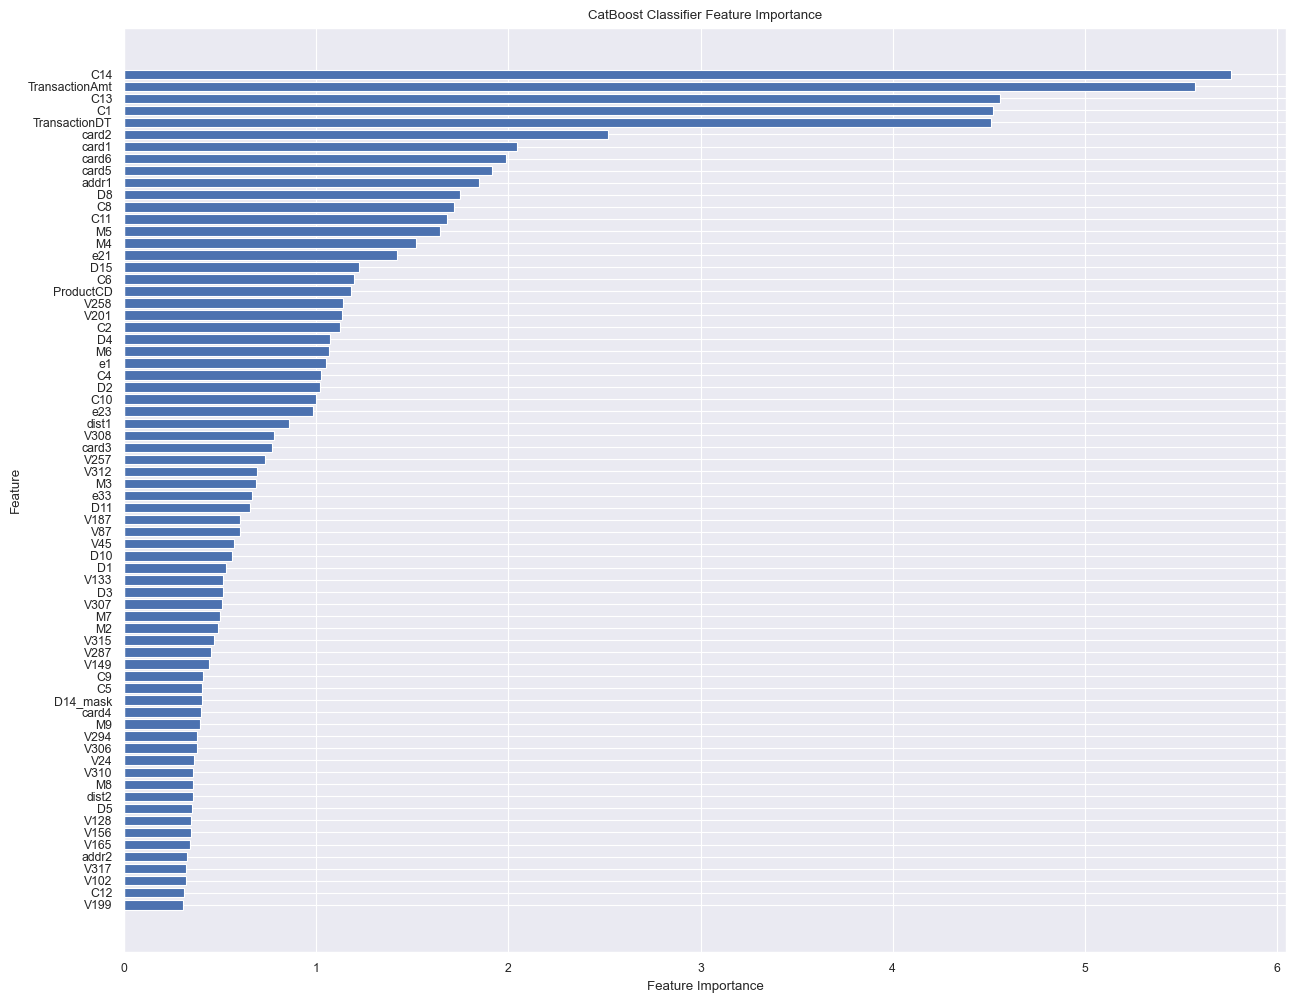

In [215]:
feature_importance = classifier.feature_importances_

# Get feature names
feature_names = train_data.get_feature_names()
sorted_idx = feature_importance.argsort()

n = 70
# Plot feature importances
plt.figure(figsize=(15, 12))
plt.barh(range(n), feature_importance[sorted_idx][-n:], align='center')
plt.yticks(range(n), [feature_names[i] for i in sorted_idx][-n:])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('CatBoost Classifier Feature Importance')
plt.show()

In [216]:
mask = feature_importance[sorted_idx]

mask = mask == 0
#feature_names[sorted_idx[mask]]

to_drop = [feature_names[k] for k in sorted_idx[mask]]

print(to_drop)

['V179_mask', 'V322_mask', 'V39_mask']


In [217]:
columns_to_drop = ['V324', 'V102_mask', 'V103_mask', 'V104_mask', 'V105_mask', 'V106_mask', 'V107_mask', 'V101_mask', 'V108_mask', 'V110_mask', 'V111_mask', 'V112_mask', 'V113_mask', 'V114_mask', 'V115_mask', 'V109_mask', 'V116_mask', 'V100_mask', 'V98_mask', 'V80_mask', 'V81_mask', 'V82_mask', 'V83_mask', 'V84_mask', 'V86_mask', 'V99_mask', 'V88_mask', 'V91_mask', 'V93_mask', 'V94_mask', 'V95_mask', 'V96_mask', 'V97_mask', 'V89_mask', 'V117_mask', 'V118_mask', 'V119_mask', 'V139_mask', 'V141_mask', 'V142_mask', 'V144_mask', 'V145_mask', 'V147_mask', 'V138_mask', 'V148_mask', 'V151_mask', 'V152_mask', 'V153_mask', 'V154_mask', 'V155_mask', 'V158_mask', 'V150_mask', 'V137_mask', 'V136_mask', 'V135_mask', 'V120_mask', 'V121_mask', 'V122_mask', 'V123_mask', 'V124_mask', 'V125_mask', 'V126_mask', 'V127_mask', 'V128_mask', 'V129_mask', 'V130_mask', 'V131_mask', 'V132_mask', 'V133_mask', 'V134_mask', 'V79_mask', 'V77_mask', 'V76_mask', 'V71_mask', 'V334', 'V335', 'V338', 'dist1_mask', 'dist2_mask', 'D1_mask', 'V333', 'D4_mask', 'D7_mask', 'D8_mask', 'D11_mask', 'V1_mask', 'V2_mask', 'V3_mask', 'D6_mask', 'V331', 'V330', 'V328', 'V248', 'V252', 'V269', 'V275', 'V278', 'V288', 'V299', 'V300', 'V305', 'V319', 'V323', 'C10_mask', 'V325', 'V326', 'V327', 'V4_mask', 'V159_mask', 'V5_mask', 'V8_mask', 'V38_mask', 'V40_mask', 'V41_mask', 'V42_mask', 'V43_mask', 'V45_mask', 'V37_mask', 'V46_mask', 'V49_mask', 'V51_mask', 'V52_mask', 'V59_mask', 'V60_mask', 'V69_mask', 'V48_mask', 'V34_mask', 'V33_mask', 'V27_mask', 'V9_mask', 'V11_mask', 'V12_mask', 'V13_mask', 'V14_mask', 'V15_mask', 'V16_mask', 'V17_mask', 'V18_mask', 'V19_mask', 'V20_mask', 'V22_mask', 'V24_mask', 'V25_mask', 'V26_mask', 'V6_mask', 'V247', 'V163_mask', 'V166_mask', 'V284_mask', 'V285_mask', 'V286_mask', 'V287_mask', 'V288_mask', 'V290_mask', 'V282_mask', 'V291_mask', 'V293_mask', 'V294_mask', 'V295_mask', 'V296_mask', 'V297_mask', 'V298_mask', 'V292_mask', 'V299_mask', 'V281_mask', 'V279_mask', 'V263_mask', 'V264_mask', 'V265_mask', 'V266_mask', 'V267_mask', 'V268_mask', 'V280_mask', 'V269_mask', 'V271_mask', 'V272_mask', 'V275_mask', 'V276_mask', 'V277_mask', 'V278_mask', 'V270_mask', 'V300_mask', 'V301_mask', 'V302_mask', 'V325_mask', 'V327_mask', 'V328_mask', 'V330_mask', 'V331_mask', 'V333_mask', 'V324_mask', 'V334_mask', 'V337_mask', 'V338_mask', 'C2_mask', 'C4_mask', 'C6_mask', 'C8_mask', 'V336_mask', 'V323_mask', 'V321_mask', 'V320_mask', 'V303_mask', 'V304_mask', 'V305_mask', 'V306_mask', 'V307_mask', 'V308_mask', 'V309_mask', 'V310_mask', 'V311_mask', 'V312_mask', 'V313_mask', 'V316_mask', 'V317_mask', 'V318_mask', 'V319_mask', 'V262_mask', 'V261_mask', 'V258_mask', 'V257_mask', 'V190_mask', 'V191_mask', 'V192_mask', 'V194_mask', 'V195_mask', 'V197_mask', 'V189_mask', 'V198_mask', 'V200_mask', 'V202_mask', 'V203_mask', 'V204_mask', 'V205_mask', 'V206_mask', 'V199_mask', 'V188_mask', 'V187_mask', 'V186_mask', 'V167_mask', 'V171_mask', 'V172_mask', 'V173_mask', 'V174_mask', 'V175_mask', 'V176_mask', 'V177_mask', 'V178_mask', 'V180_mask', 'V181_mask', 'V182_mask', 'V183_mask', 'V184_mask', 'V185_mask', 'V209_mask', 'V164_mask', 'V210_mask', 'V214_mask', 'V240_mask', 'V241_mask', 'V242_mask', 'V243_mask', 'V244_mask', 'V246_mask', 'V239_mask', 'V247_mask', 'V251_mask', 'V252_mask', 'V253_mask', 'V254_mask', 'V255_mask', 'V256_mask', 'V250_mask', 'V238_mask', 'V237_mask', 'V236_mask', 'V215_mask', 'V216_mask', 'V217_mask', 'V219_mask', 'V220_mask', 'V223_mask', 'V224_mask', 'V225_mask', 'V228_mask', 'V229_mask', 'V230_mask', 'V231_mask', 'V232_mask', 'V233_mask', 'V235_mask', 'V211_mask', 'V244', 'C12_mask', 'V197', 'V117', 'V12', 'V116', 'V10', 'V9', 'V115', 'V152', 'V114', 'V113', 'V111', 'V110', 'V32', 'V108', 'V107', 'V198', 'V104', 'V16', 'V196', 'V1', 'V118', 'V233', 'V119', 'V14', 'V213', 'V145', 'V146', 'V138', 'V137', 'V18', 'V218', 'V241', 'V33', 'V124', 'V123', 'V151', 'V122', 'V224', 'V225', 'V226', 'V121', 'V177', 'V120', 'V229', 'V99', 'V142', 'V28', 'V88', 'V22', 'V84', 'V48', 'V80', 'V27', 'V235', 'V68', 'V158', 'V157', 'V89', 'V185', 'V41', 'V237', 'V65', 'M1', 'V61', 'V183', 'V57', 'V180', 'V179', 'V184']
columns_to_drop += ['D5_mask', 'V32_mask', 'V112', 'V125', 'V19', 'V335_mask', 'V36_mask', 'V194', 'V44_mask', 'V8', 'V7', 'V4', 'V47_mask', 'V190', 'V295', 'V62_mask', 'V64_mask', 'V78_mask', 'V105', 'V87_mask', 'V31_mask', 'V30_mask', 'V297', 'V286', 'V302', 'V52', 'V73', 'V249', 'V46', 'V238', 'V95', 'D10_mask', 'D12_mask', 'V7_mask', 'V10_mask', 'V236', 'V21_mask', 'V28_mask', 'V101', 'V103', 'V92_mask', 'V58_mask', 'V143_mask', 'V201_mask', 'V208_mask', 'V212_mask', 'V218_mask', 'V140_mask', 'V175', 'V226_mask', 'V234_mask', 'V248_mask', 'V249_mask', 'V260_mask', 'V273_mask', 'V274_mask', 'V329_mask', 'V332_mask', 'V154', 'V170_mask', 'V176', 'V182', 'V146_mask', 'V149_mask', 'V156_mask', 'V169_mask', 'V147', 'V148', 'V63', 'V168_mask', 'V165_mask']

save_json(columns_to_drop, './artifacts/columns_to_drop.json')